In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import norm
import tqdm

np.random.seed(42)

## Implement logistic regression from scratch.


$$\textrm{log-likelihood, }\ell(\theta) = \log L(\theta) = \sum_{i=1}^n \left[ y^{(i)} \log h_\theta(x^{(i)}) + (1 - y^{(i)}) \log (1 - h_\theta(x^{(i)})) \right]$$

$$ \mathbf{\implies \ell(\theta)} = \mathbf{Y}.log(\mathbf{h_\theta(X)}) + (1 - \mathbf{Y}). log(\mathbf{1 - h_\theta(X)}) $$


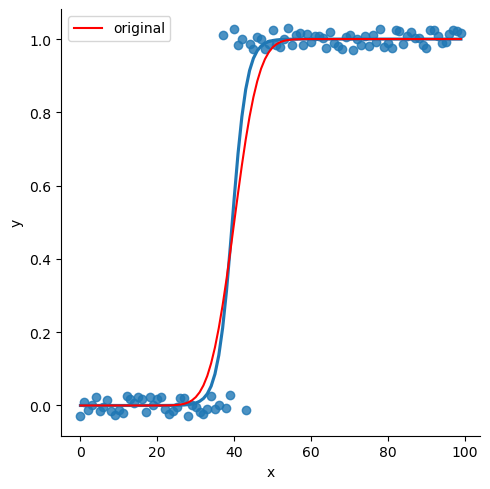

In [3]:
# for simplicity the dimensions of the data , X is 100, 1 only

# creating custom binary classification data
data_x = np.arange(0, 100)

# using the gaussian cdf to generate desired probabilities
probabilities = norm.cdf(data_x, loc=40, scale=5)
random_vals = np.random.random(data_x.shape)

data_y = np.where(random_vals < probabilities, 1, 0)

df = pd.DataFrame({'x': data_x, 'y': data_y})
sns.lmplot(x="x", y="y", data=df, logistic=True, ci=None, y_jitter=0.03)
plt.plot(data_x, probabilities, color='red', label='original')
plt.legend()

In [4]:
# intial theta
# theta_initial = np.array([2, -40])
theta_initial = np.array([0, 0])

# writing the function to be maximised
def sigmoid(x_i, theta):
    # introduce extra dimension for the constant part
    x_array = np.array([x_i, 1])
    return 1/(1 + np.exp(-np.dot(x_array, theta)))

def create_h_arr(x, theta):
    return np.array([sigmoid(x_i, theta) for x_i in x])  #TODO: way to vectorize?

# h(data_x, theta_initial)

In [5]:
# define the log likelihood function

def log_likelihood_fn(theta, x, y):
    h_array = create_h_arr(theta, x)
    log_likelihood = y.dot(np.log(h_array)) + (1-y).dot(np.log(1-h_array))
    
    return log_likelihood


for gradient ascent
$$ \theta : = \theta + \alpha \nabla_\theta \ell (\theta )$$
for stochastic gradient ascent
$$ \theta_j : = \theta_j + \alpha \big( y^{(i)} - h(x^{(i)}) \big)x_j^{(i)} $$

where $\alpha$ is the learning rate
$\theta$ in our case is of dimensions $(2,1)$

In [ ]:
# class of all optimizers

class optimize:
    def init(self, x, y):
        self.x = x
        self.y = y

    def calculate_gradient(self, theta, x_i, y_i):
        """
        calculate gradient for 1 training example
        """
        x_arr = np.array([x_i, 1])
        grad = (y_i - sigmoid(x_i, theta))*x_arr

        return grad

    # def batch_gradient_ascent_step(self, theta, learning_rate):
    #     theta_new = theta
    #     for x_i, y_i in self.x, self.y:
    #         theta_new += learning_rate * self.calculate_gradient(theta, x_i, y_i)

    #     return theta_new
    
    # Stochastic gradient ascent using random indexes
    # def stochastic_gradient_ascent_step(self, theta, learning_rate):
    #     random_index = np.random.randint(0, self.x.shape[0])
    #     theta_new = theta + learning_rate * self.calculate_gradient(theta, self.x[random_index], self.y[random_index])
        
    #     return theta_new
    
    def fisher_scoring(self, theta):
        pass

    def batch_gradient_ascent(self, theta_initial, learning_rate, epochs):
        theta = theta_initial
        for epoch in tqdm.tqdm(range(epochs)):
            theta_new = theta
            for x_i, y_i in self.x, self.y:
                theta_new += learning_rate * self.calculate_gradient(theta, x_i, y_i)
            print(f"epoch: {epoch} -> theta: {theta_new}")

    def stochastic_gradient_ascent(self, theta_initial, learning_rate, epochs):
        theta = theta_initial
        for epoch in tqdm.tqdm(range(epochs)):
            for x_i, y_i in self.x, self.y:
                theta += learning_rate * self.calculate_gradient(theta, x_i, y_i)



In [8]:
# plotting the actual graph

In [9]:
# plotting theta vs epochs

In [10]:
# plotting MSE vs epochs